In [2]:
%config Completer.use_jedi = False

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

Pandas Settings:

In [7]:
pd.set_option("max_colwidth", 150)
pd.set_option("display.max_columns", 60)
pd.set_option('max_rows', None)
# pd.set_option("max_colwidth", 250)

In [8]:
df_train = pd.read_csv(r'C:\Users\ggomp\OneDrive\Documents\GitHub\Kaggle_Competitions\titanic_classification\datasets\train.csv')
df_test = pd.read_csv(r'C:\Users\ggomp\OneDrive\Documents\GitHub\Kaggle_Competitions\titanic_classification\datasets\test.csv')
df_sub = pd.read_csv(r'C:\Users\ggomp\OneDrive\Documents\GitHub\Kaggle_Competitions\titanic_classification\datasets\gender_submission.csv')

display(df_train.head(5))
display(df_test.head(5))
# display(df_sub)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Okay heres the order for the MVP training set:
1. Drop non-MVP columns
1. Drop NaN values
1. OHC Sex column
1. Split X and Y
1. Fit
1. Score

1. Drop non-MVP columns from both train and test sets

In [9]:
train_copy = df_train.copy()
train_mvp = train_copy.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
display(train_mvp.head(5))

test_copy = df_test.copy()
test_mvp = test_copy.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
display(test_mvp.head(5))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Checking for NaN values in Sex column

In [10]:
print("df_train:\n", df_train.isnull().sum())
print()
print(train_mvp.isnull().sum())

# print(train_mvp['Embarked'].isnull())

df_train:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


3. OHC Sex Column

In [11]:
train_mvp_c = train_mvp.copy()
train_mvp_c = pd.get_dummies(train_mvp_c,prefix=['Sex'], columns = ['Sex'], drop_first=True)
display(train_mvp_c.head(5))



train_mvp_c = pd.get_dummies(train_mvp_c,prefix=['Embarked'], columns = ['Embarked'], drop_first=True)
display(train_mvp_c.iloc[59:64])

print(train_mvp_c.isnull().sum())



test_mvp_c = test_mvp.copy()
test_mvp_c = pd.get_dummies(test_mvp_c,prefix=['Sex'], columns = ['Sex'], drop_first=True)
# display(test_mvp_c.head(25))

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_male
0,0,3,22.0,1,0,7.2500,S,1
1,1,1,38.0,1,0,71.2833,C,0
2,1,3,26.0,0,0,7.9250,S,0
3,1,1,35.0,1,0,53.1000,S,0
4,0,3,35.0,0,0,8.0500,S,1


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
59,0,3,11.0,5,2,46.9000,1,0,1
60,0,3,22.0,0,0,7.2292,1,0,0
61,1,1,38.0,0,0,80.0000,0,0,0
62,0,1,45.0,1,0,83.4750,1,0,1
63,0,3,4.0,3,2,27.9000,1,0,1


Survived        0
Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_male        0
Embarked_Q      0
Embarked_S      0
dtype: int64


2. Imputting NaN values

In [12]:
imputer = IterativeImputer()
# imputer = KNNImputer(n_neighbors=8)

train_mvp_c = imputer.fit_transform(train_mvp_c)
train_mvp_c = pd.DataFrame(train_mvp_c)
display(train_mvp_c.head(10))

# train_mvp_c = train_mvp_c.reindex_like(train_mvp)
# columns = ['Survived', Pclass]


,0,1,2,3,4,5,6,7,8
0,0.0,3.0,22.00000,1.0,0.0,7.2500,1.0,0.0,1.0
1,1.0,1.0,38.00000,1.0,0.0,71.2833,0.0,0.0,0.0
2,1.0,3.0,26.00000,0.0,0.0,7.9250,0.0,0.0,1.0
3,1.0,1.0,35.00000,1.0,0.0,53.1000,0.0,0.0,1.0
4,0.0,3.0,35.00000,0.0,0.0,8.0500,1.0,0.0,1.0
5,0.0,3.0,30.73029,0.0,0.0,8.4583,1.0,1.0,0.0
6,0.0,1.0,54.00000,0.0,0.0,51.8625,1.0,0.0,1.0
7,0.0,3.0,2.00000,3.0,1.0,21.0750,1.0,0.0,1.0
8,1.0,3.0,27.00000,0.0,2.0,11.1333,0.0,0.0,1.0
9,1.0,2.0,14.00000,1.0,0.0,30.0708,0.0,0.0,0.0


2. Drop NaN values


In [46]:
train_mvp = train_mvp.dropna(axis = 0)
train_mvp = train_mvp.reset_index(drop=True)
display(train_mvp)

test_mvp = test_mvp.dropna(axis = 0)
test_mvp = test_mvp.reset_index(drop=True)
display(test_mvp)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.00,1,0,7.2500,S
1,1,1,female,38.00,1,0,71.2833,C
2,1,3,female,26.00,0,0,7.9250,S
3,1,1,female,35.00,1,0,53.1000,S
4,0,3,male,35.00,0,0,8.0500,S
5,0,1,male,54.00,0,0,51.8625,S
6,0,3,male,2.00,3,1,21.0750,S
7,1,3,female,27.00,0,2,11.1333,S
8,1,2,female,14.00,1,0,30.0708,C
9,1,3,female,4.00,1,1,16.7000,S


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.50,0,0,7.8292,Q
1,3,female,47.00,1,0,7.0000,S
2,2,male,62.00,0,0,9.6875,Q
3,3,male,27.00,0,0,8.6625,S
4,3,female,22.00,1,1,12.2875,S
5,3,male,14.00,0,0,9.2250,S
6,3,female,30.00,0,0,7.6292,Q
7,2,male,26.00,1,1,29.0000,S
8,3,female,18.00,0,0,7.2292,C
9,3,male,21.00,2,0,24.1500,S


3. Split X and Y

In [13]:
X, Y = train_mvp_c.iloc[:,1:], train_mvp_c.iloc[:, 0]

display(X.head(6))
display(Y.head(6))

,1,2,3,4,5,6,7,8
0,3.0,22.00000,1.0,0.0,7.2500,1.0,0.0,1.0
1,1.0,38.00000,1.0,0.0,71.2833,0.0,0.0,0.0
2,3.0,26.00000,0.0,0.0,7.9250,0.0,0.0,1.0
3,1.0,35.00000,1.0,0.0,53.1000,0.0,0.0,1.0
4,3.0,35.00000,0.0,0.0,8.0500,1.0,0.0,1.0
5,3.0,30.73029,0.0,0.0,8.4583,1.0,1.0,0.0


0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
5    0.0
Name: 0, dtype: float64

Listing all classification models in SKlearn

In [43]:
#imports for looking at all potential models - this can be removed afterwards
from sklearn.base import ClassifierMixin
from sklearn.utils import all_estimators

classifiers = [est for est in all_estimators() if issubclass(est[1], ClassifierMixin)]
display(classifiers)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble._weight_boosting import AdaBoostClassifier
from sklearn.ensemble._bagging import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import ClassifierChain
from sklearn.tree._classes import DecisionTreeClassifier
from sklearn.ensemble._forest import ExtraTreesClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble._gb import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm._classes import LinearSVC
from sklearn.linear_model._logistic import LogisticRegression
from sklearn.neural_network._multilayer_perceptron import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm._classes import NuSVC
from sklearn.linear_model._passive_aggressive import PassiveAggressiveClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.linear_model._ridge import RidgeClassifier
from sklearn.linear_model._stochastic_gradient import SGDClassifier
from sklearn.svm._classes import SVC
from sklearn.ensemble._stacking import StackingClassifier
from sklearn.ensemble._voting import VotingClassifier

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('ClassifierChain', sklearn.multioutput.ClassifierChain),
 ('ComplementNB', sklearn.naive_bayes.ComplementNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('GaussianProcessClassifier',
  sklearn.gaussian_process._gpc.GaussianProcessClassifier),
 ('GradientBoostingClassifier',
  sklearn.ensemble._gb.GradientBoostingClassifier),
 ('HistGradientBoostingClassifier',
  sklearn.ensemble._hist_gradi

Creating List of Models

In [91]:
models = [('AdaBoost', Pipeline([("scaling", StandardScaler()), ("model", AdaBoostClassifier())])),
          ('KNN', Pipeline([("scaling", StandardScaler()), ("model", KNeighborsClassifier())])),
          ('BagClass', Pipeline([("scaling", StandardScaler()), ("model", BaggingClassifier())])),
          ('Bernouli', Pipeline([("scaling", StandardScaler()), ("model", BernoulliNB())])),
          ('Calibrated', Pipeline([("scaling", StandardScaler()), ("model", CalibratedClassifierCV(n_jobs=20))])),
          ('DecisionT', Pipeline([("scaling", StandardScaler()), ("model", DecisionTreeClassifier())])),
          ('ExtraTrees', Pipeline([("scaling", StandardScaler()), ("model", ExtraTreesClassifier())])),
          ('GaussNB', Pipeline([("scaling", StandardScaler()), ("model", GaussianNB())])),
          ('GBoostC', Pipeline([("scaling", StandardScaler()), ("model", GradientBoostingClassifier())])),
          ('LDA', Pipeline([("scaling", StandardScaler()), ("model", LinearDiscriminantAnalysis())])),
          ('LogisticR', Pipeline([("scaling", StandardScaler()), ("model", LogisticRegression())])),
          ('MLP', Pipeline([("scaling", StandardScaler()), ("model", MLPClassifier(hidden_layer_sizes=(100,8), max_iter=500))])),
          ('NuSVC', Pipeline([("scaling", StandardScaler()), ("model", NuSVC())])),
          ('PAC', Pipeline([("scaling", StandardScaler()), ("model", PassiveAggressiveClassifier())])),
          ('QDA', Pipeline([("scaling", StandardScaler()), ("model", QuadraticDiscriminantAnalysis())])),
          ('RandomF', Pipeline([("scaling", StandardScaler()), ("model", RandomForestClassifier())])),
          ('RidgeC', Pipeline([("scaling", StandardScaler()), ("model", RidgeClassifier())])),
          ('SGD', Pipeline([("scaling", StandardScaler()), ("model", SGDClassifier())])),
          ('SVC', Pipeline([("scaling", StandardScaler()), ("model", SVC())]))]
         
           
# ('Classchain', Pipeline([("scaling", StandardScaler()), ("model", ClassifierChain(base_estimator=LogisticRegression()))])),
# ('MultiNB', Pipeline([("scaling", StandardScaler()), ("model", MultinomialNB())])),
# ('L-SVC', Pipeline([("scaling", StandardScaler()), ("model", LinearSVC())])),
# ('StackingC', Pipeline([("scaling", StandardScaler()), ("model", StackingClassifier(estimators=LogisticRegression()))])),
# ('VotingC', Pipeline([("scaling", StandardScaler()), ("model", VotingClassifier(estimators=LogisticRegression()))])),

In [92]:
# Test options and evaluation metric
num_folds = 10
seed = 1
scoring = 'accuracy'

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

In [93]:
results = [] 
names = []
for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

AdaBoost: 0.809251 (0.041158)
KNN: 0.812597 (0.025908)
BagClass: 0.821610 (0.048009)
Bernouli: 0.764345 (0.036662)
Calibrated: 0.811473 (0.037046)
DecisionT: 0.795705 (0.038005)
ExtraTrees: 0.815943 (0.050774)
GaussNB: 0.789064 (0.051599)
GBoostC: 0.831710 (0.046845)
LDA: 0.804732 (0.029678)
LogisticR: 0.809226 (0.039756)
MLP: 0.826067 (0.037860)
NuSVC: 0.821610 (0.045303)
PAC: 0.685918 (0.085358)
QDA: 0.805905 (0.041014)
RandomF: 0.821610 (0.046404)
RidgeC: 0.804732 (0.032129)
SGD: 0.753196 (0.059868)
SVC: 0.822772 (0.046230)


Visual Comparison of Models

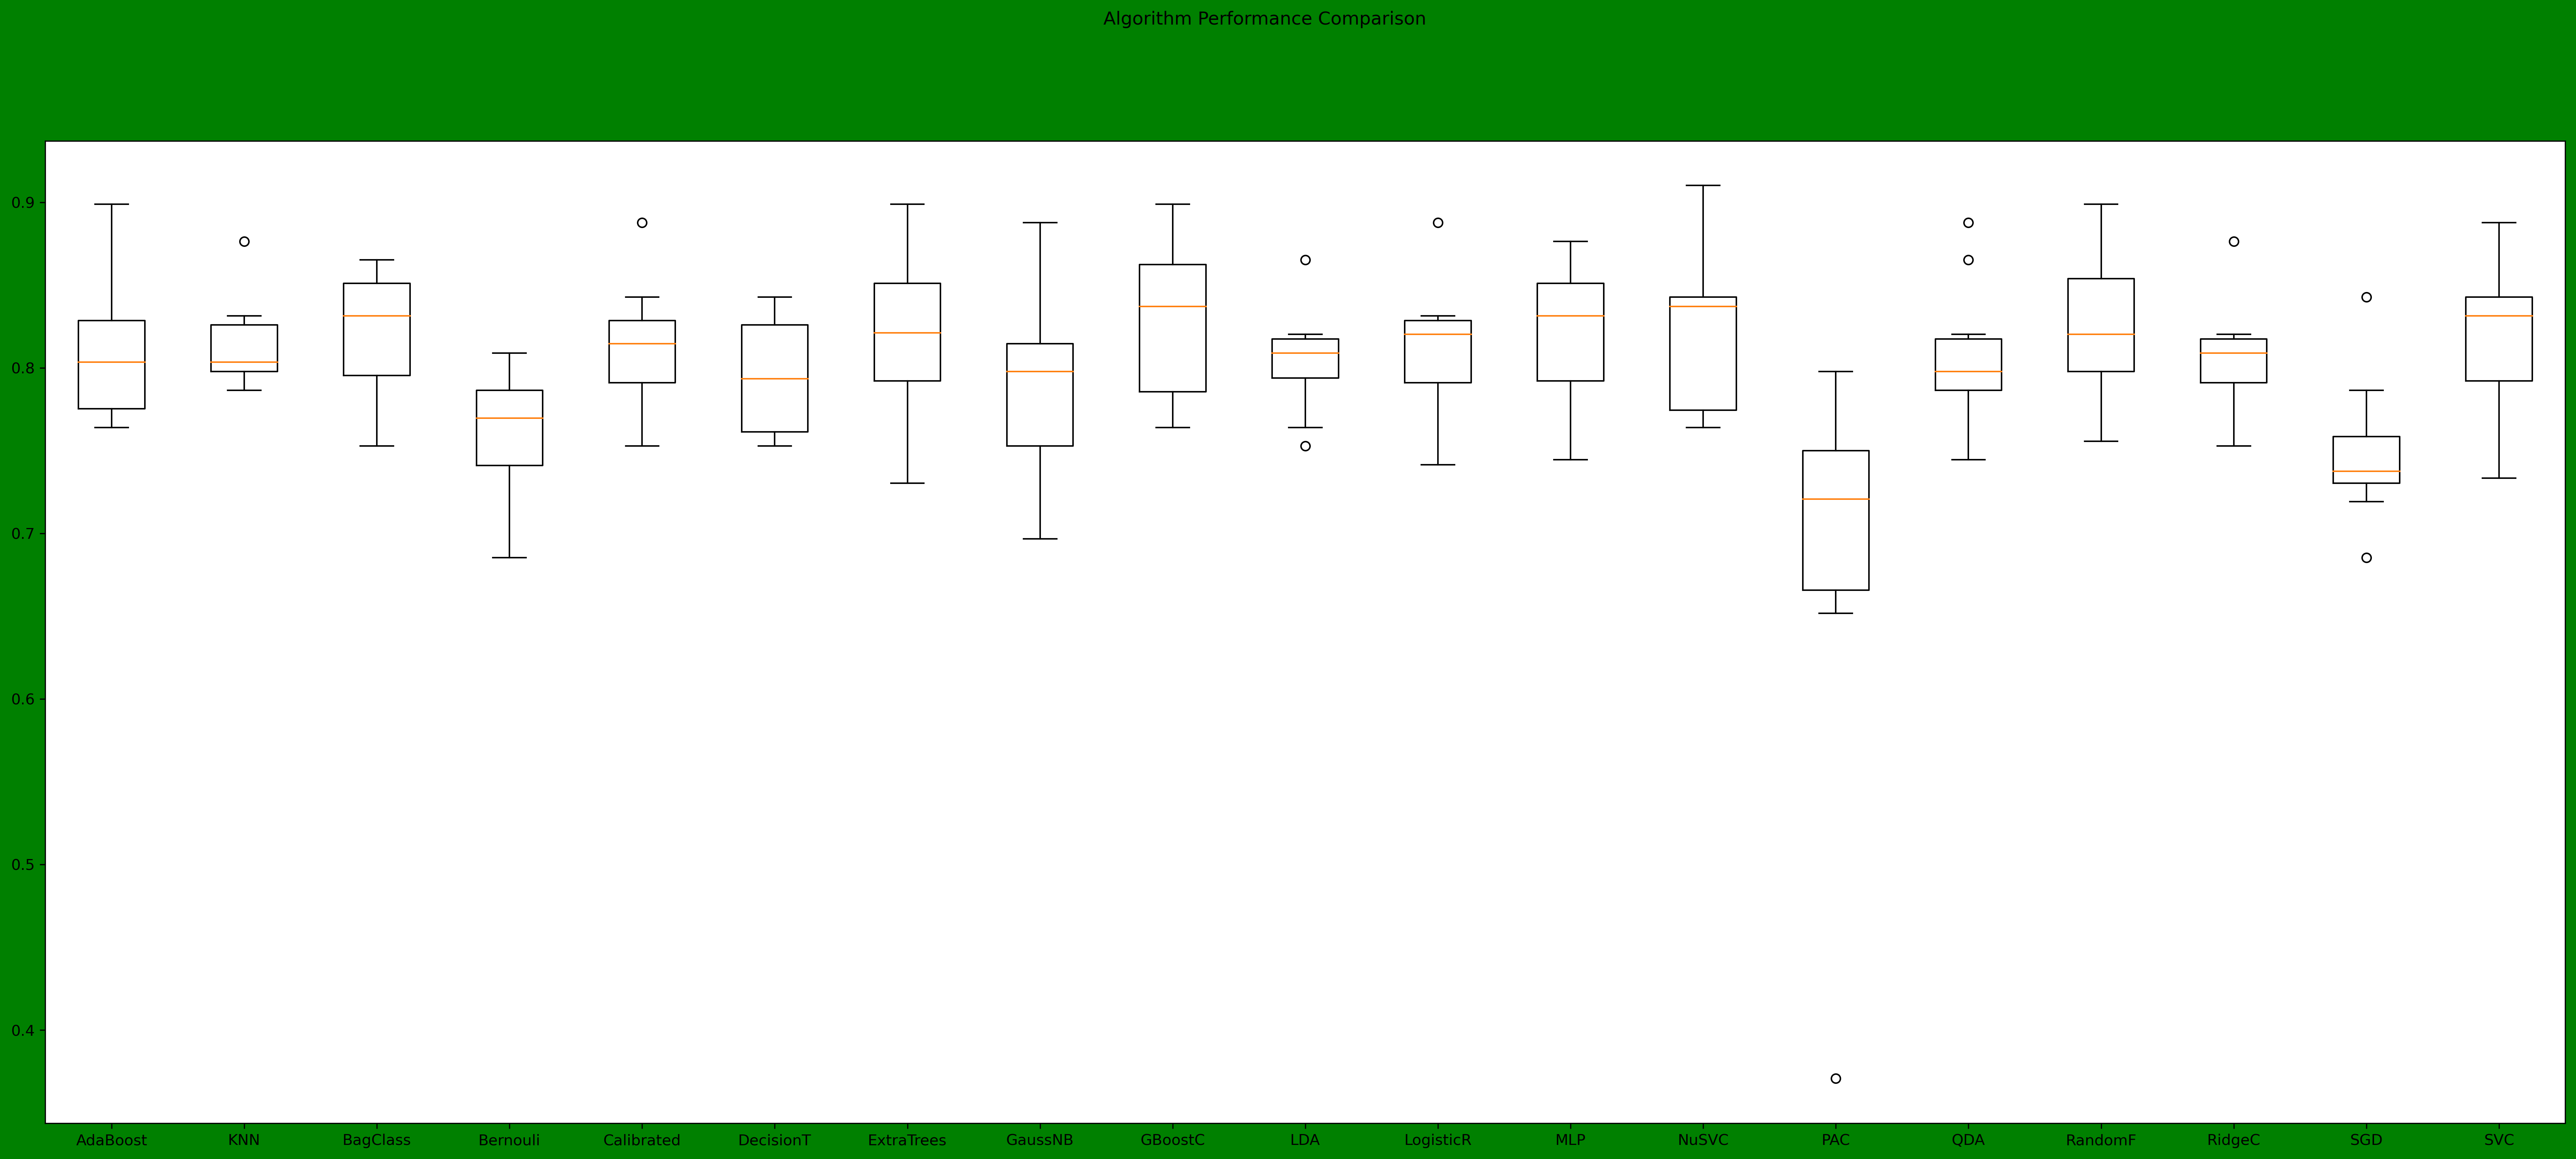

In [65]:
fig = plt.figure(figsize=(30,12), dpi= 300, facecolor='g', edgecolor='w')
fig.suptitle('Algorithm Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

4. Create Pipeline

In [89]:
pipe = Pipeline([("scaling", StandardScaler()), ("model", KNeighborsClassifier(n_neighbors=5))])
# pipe.get_params()

5. Create GridSearchCV

In [90]:
model = GridSearchCV(estimator = pipe, 
                     param_grid = {'model__n_neighbors': [6,7,8,9,10,11,12,13,14, 18, 22]},
                     cv=10)

6. Model.fit

In [91]:
# %%timeit 

model.fit(X, Y)
df_results = pd.DataFrame(model.cv_results_)

highest_acc = df_results['mean_test_score'].max()
print(highest_acc)
print()
display(df_results)


0.8316604244694131



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009696,0.004783,0.007431,0.004430,6,{'model__n_neighbors': 6},0.800000,0.842697,0.741573,0.831461,0.853933,0.842697,0.842697,0.808989,0.887640,0.752809,0.820449,0.043114,9
1,0.005207,0.003590,0.004700,0.003850,7,{'model__n_neighbors': 7},0.822222,0.831461,0.764045,0.853933,0.865169,0.831461,0.876404,0.786517,0.853933,0.820225,0.830537,0.033067,2
2,0.004132,0.004149,0.004805,0.003923,8,{'model__n_neighbors': 8},0.822222,0.831461,0.764045,0.853933,0.831461,0.831461,0.853933,0.786517,0.876404,0.786517,0.823795,0.033335,5
3,0.004004,0.004004,0.004796,0.003916,9,{'model__n_neighbors': 9},0.811111,0.831461,0.764045,0.865169,0.831461,0.820225,0.831461,0.786517,0.842697,0.831461,0.821561,0.027180,8
4,0.004802,0.003921,0.004000,0.004000,10,{'model__n_neighbors': 10},0.822222,0.842697,0.764045,0.876404,0.865169,0.842697,0.853933,0.786517,0.853933,0.808989,0.831660,0.034020,1
5,0.003866,0.004068,0.005306,0.003581,11,{'model__n_neighbors': 11},0.811111,0.831461,0.775281,0.853933,0.842697,0.842697,0.808989,0.797753,0.842697,0.831461,0.823808,0.023472,4
6,0.004955,0.004065,0.003201,0.003920,12,{'model__n_neighbors': 12},0.822222,0.820225,0.764045,0.876404,0.853933,0.831461,0.820225,0.786517,0.853933,0.797753,0.822672,0.032088,7
7,0.005596,0.003664,0.002399,0.003665,13,{'model__n_neighbors': 13},0.811111,0.820225,0.764045,0.853933,0.865169,0.831461,0.820225,0.808989,0.853933,0.797753,0.822684,0.028686,6
8,0.003690,0.003683,0.004493,0.003779,14,{'model__n_neighbors': 14},0.833333,0.820225,0.775281,0.876404,0.865169,0.820225,0.831461,0.797753,0.865169,0.797753,0.828277,0.031426,3
9,0.004805,0.003924,0.003335,0.003827,18,{'model__n_neighbors': 18},0.800000,0.797753,0.775281,0.865169,0.842697,0.797753,0.831461,0.775281,0.865169,0.797753,0.814831,0.032162,10


In [ ]:
df_preds = pd.DataFrame(model.predict(test_mvp))
display(df_preds.head(50))

df_preds.

Notes from feature engineering:

Null accuracy                    = 61.7%

Drop NaNs with numeric columns   = 58.6% (train) base

OHC of sex column:               = 64.7% (train) +6%

IterativeImputer                 = 83.8% (train) +19%

OHC of Embarked column           = 83.1% (train) -.7%

QuantileTransformer              = 82.2% (train) -.9%

PolynomialFeatures (scaler)      = 71.2% (train) -11%

AutoPilot Accuracy               = 84.7% (train)